In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import time 


In [2]:
import sys
sys.path.insert(1, "../")


from models import EmbeddingLayer
from models import define_model

from utils import loglin_transform


In [3]:
from chainconsumer import ChainConsumer


# Fig 1 and sampling time

In [4]:
mcmcpoints_parlist=[
       [-14.5,   2.5],
       [-14.5,   4.5],
       [-15.5,   2.5],
       [-15.5,   4.5]]



In [5]:
testpoints_grid={}
testpoints_grid_transf={}
for par in mcmcpoints_parlist:
    testpoints_grid[par[0],par[1]]=np.load('../data/testpoints_grid/testpoints_fLDeltaf0.01_10p_withRN_forsteve_newRN_'+str(par[0])+'_'+str(par[1])+'_proj.npy')
    testpoints_grid_transf[par[0],par[1]]=loglin_transform(testpoints_grid[par[0],par[1]]*1e7,1000)


In [6]:
parmin=np.array([-18,1,-19,-19,-19,-19,-19,-19,-19,-19,-19,-19,1,1,1,1,1,1,1,1,1,1])
parmax=np.array([-13,7,-13,-13,-13,-13,-13,-13,-13,-13,-13,-13,7,7,7,7,7,7,7,7,7,7])


In [7]:
os.environ["CUDA_VISIBLE_DEVICES"]='0,1,2'


CUDA = True
device = torch.device("cuda:0" if CUDA else "cpu")

kwargs = {'num_workers': 4, 'pin_memory': True} if CUDA else {}
kwargs = {}


In [8]:
ntoalist=[405, 444, 299, 233, 259, 275, 133, 265, 167, 460]

embedding=EmbeddingLayer(ntoalist,noutput=50)

#(ninputlist=(np.array(ntoalist)).tolist(),noutput=20,nsingle=20)
model=define_model(nfeatures=22,nhidden=2,hidden_size=200,embedding=embedding,dropout=0,nembedding=50)
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
####    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    embedding = nn.DataParallel(embedding)
#####    logprob_parallel=nn.DataParallel(model.log_prob)
    model = nn.DataParallel(model)
embedding=embedding.to(device)
model=model.to(device)



../models.py:221: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.output.weight)
../models.py:338: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.output.weight)


50
Flow_with_forward(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=22, out_features=200, bias=True)
          (context_layer): Linear(in_features=50, out_features=200, bias=True)
          (blocks): ModuleList(
            (0): MaskedFeedforwardBlock(
              (linear): MaskedLinear(in_features=200, out_features=200, bias=True)
              (dropout): Dropout(p=0, inplace=False)
            )
            (1): MaskedFeedforwardBlock(
              (linear): MaskedLinear(in_features=200, out_features=200, bias=True)
              (dropout): Dropout(p=0, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=200, out_features=506, bias=True)
        )
      )
      (1): ReversePermutation()
      (2): MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        (autore

In [9]:
flow_samples={}
for ii,par in enumerate(mcmcpoints_parlist):
    print(ii,par)
    with torch.no_grad():
#        testpoint_transf=testpoints_transf[ii]
        iepoch=87
        model.load_state_dict(torch.load('../trained_models/babydataset_1M_fLDeltaf0.01_10p_withRN_SinglePulsarStackedLSTM_v2/babydataset_fLDeltaf0.01_epoch_'+str(iepoch)+'_Model.par'))
        model.eval()
        t0=time.time()
        testposterior=model.module.sample(100000,
                              torch.from_numpy(testpoints_grid_transf[par[0],par[1]].reshape((1,2940)).astype('float32')).to(device)\
                               )
        t1=time.time()
        print(t1-t0)
        testposterior=testposterior.cpu().detach().numpy()
        datatry=testposterior.reshape((100000,-1))
        datatry=0.5*(parmin + parmax + (parmax-parmin)*datatry)
        flow_samples[par[1],par[0]]=datatry
   
   

0 [-14.5, 2.5]
10.553497791290283
1 [-14.5, 4.5]
10.497138261795044
2 [-15.5, 2.5]
10.485930919647217
3 [-15.5, 4.5]
10.479602813720703


In [10]:
mcmcpoints_grid=np.load('../data/mcmc_chains_pargrid.npy')

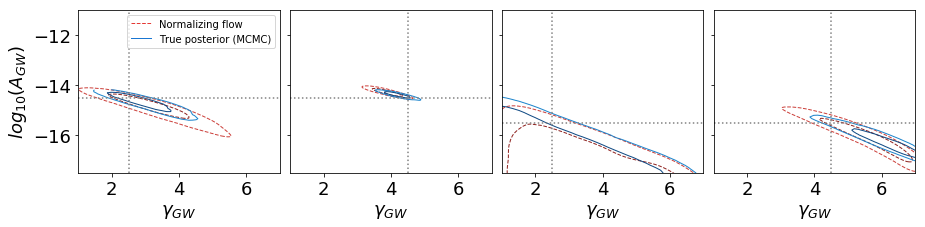

In [11]:
from matplotlib.lines import Line2D
cmap = plt.cm.coolwarm


fig, ax = plt.subplots(1,4,figsize=(15,3), sharey=True, gridspec_kw={'wspace': .05})

parnames=["$\gamma_{GW}$", "$log_{10}(A_{GW})$"]
for ii,par in enumerate(mcmcpoints_parlist):
    datatry=flow_samples[par[1],par[0]]
    c = ChainConsumer()
    c.add_chain(np.dstack((datatry[:,1],datatry[:,0]))[0], parameters=parnames,\
                color='red',name='Normalizing flow',smooth=.5,bins=50,linestyle="dashed",shade=False,kde=2)

    c.add_chain(mcmcpoints_grid[ii],\
    parameters=parnames,name='True posterior (MCMC) ',color='blue',\
                shade_alpha=0.2,smooth=.2,bins=50,shade=False,kde=2)
    c.plotter.plot_contour(ax[ii], parnames[0], parnames[1])
    ax[ii].axvline(par[1],color='gray',linestyle='dotted')
    ax[ii].axhline(par[0],color='gray',linestyle='dotted')

ax[0].set_xlabel(parnames[0],fontsize=18)
ax[0].tick_params(labelsize=18)
ax[0].set_xlim(1,7)

ax[1].set_xlabel(parnames[0],fontsize=18)
ax[1].tick_params(labelsize=18)
ax[1].set_xlim(1,7)

ax[2].set_xlabel(parnames[0],fontsize=18)
ax[2].tick_params(labelsize=18)
ax[2].set_xlim(1,7)

ax[3].set_xlabel(parnames[0],fontsize=18)
ax[3].tick_params(labelsize=18)
ax[3].set_xlim(1,7)

ax[0].set_ylabel(parnames[1],fontsize=18)
ax[0].set_ylim(-17.5,-11) 

# I got these hex color numbers from 
# ~/.local/lib/python3.7/site-packages/chainconsumer/colors.py
custom_lines = [Line2D([0], [0], color="#E53935", lw=1,ls='dashed'),
                Line2D([0], [0], color="#1976D2", lw=1)]
#                Line2D([0], [0], color=cmap(1.), lw=4)]
ax[0].legend(custom_lines, ['Normalizing flow', 'True posterior (MCMC)'],fontsize=10)

plt.savefig('mcmcpoints_grid_no1d_noshade_kde.pdf',bbox_inches="tight")

# Fig 2

In [12]:
mcmcpoints=np.load('../data/mcmc_chains_nominal.npy')

In [13]:
testpoints_nominal=[]
for ii in range(4):
    testpoints_nominal.append(np.load('../data/testpoints_nominal/testpoints_fLDeltaf0.01_10p_withRN_forsteve_newRN_nominal_proj_'+str(ii+1)+'.npy'))

    
testpoints_nominal=np.array(testpoints_nominal) 
print(testpoints_nominal.shape)

(4, 2940)


In [14]:
testpoints_transf=loglin_transform(testpoints_nominal*1e7,1000)
    

In [15]:
flow_samples={}
for ii in range(len(testpoints_transf)):
    print(ii)
    with torch.no_grad():
#        testpoint_transf=testpoints_transf[ii]
        iepoch=87
        model.load_state_dict(torch.load('../trained_models/babydataset_1M_fLDeltaf0.01_10p_withRN_SinglePulsarStackedLSTM_v2/babydataset_fLDeltaf0.01_epoch_'+str(iepoch)+'_Model.par'))
        model.eval()
        t0=time.time()
        testposterior=model.module.sample(100000,
                              torch.from_numpy(testpoints_transf[ii].reshape((1,2940)).astype('float32')).to(device)\
                               )
        t1=time.time()
        print(t1-t0)
        testposterior=testposterior.cpu().detach().numpy()
        datatry=testposterior.reshape((100000,-1))
        datatry=0.5*(parmin + parmax + (parmax-parmin)*datatry)
        flow_samples[ii]=datatry
   
   

0
10.482011079788208
1
10.4853675365448
2
10.477440595626831
3
10.48435926437378


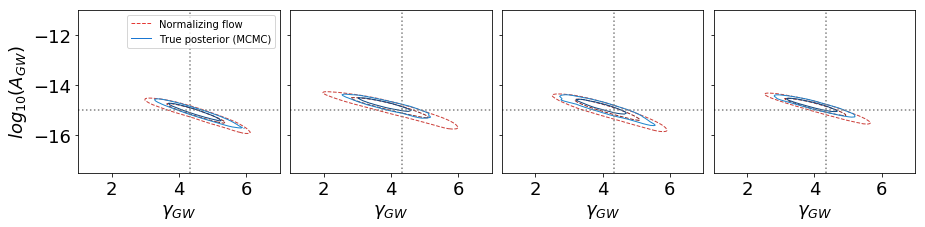

In [16]:
from matplotlib.lines import Line2D
cmap = plt.cm.coolwarm


fig, ax = plt.subplots(1,4,figsize=(15,3), sharey=True, gridspec_kw={'wspace': .05})

parnames=["$\gamma_{GW}$", "$log_{10}(A_{GW})$"]
for ii in range(4):
    c = ChainConsumer()
    c.add_chain(flow_samples[ii][:,[1,0]], parameters=parnames,\
                color='red',name='Normalizing flow',smooth=.5,bins=50,linestyle="dashed",shade=False,kde=2)

    c.add_chain(mcmcpoints[ii],\
    parameters=parnames,name='True posterior (MCMC) ',color='blue',\
                shade_alpha=0.2,smooth=.2,bins=50,shade=False,kde=2)
    c.plotter.plot_contour(ax[ii], parnames[0], parnames[1])
    ax[ii].axvline(13/3,color='gray',linestyle='dotted')
    ax[ii].axhline(-15,color='gray',linestyle='dotted')

ax[0].set_xlabel(parnames[0],fontsize=18)
ax[0].tick_params(labelsize=18)
ax[0].set_xlim(1,7)

ax[1].set_xlabel(parnames[0],fontsize=18)
ax[1].tick_params(labelsize=18)
ax[1].set_xlim(1,7)

ax[2].set_xlabel(parnames[0],fontsize=18)
ax[2].tick_params(labelsize=18)
ax[2].set_xlim(1,7)

ax[3].set_xlabel(parnames[0],fontsize=18)
ax[3].tick_params(labelsize=18)
ax[3].set_xlim(1,7)

ax[0].set_ylabel(parnames[1],fontsize=18)
ax[0].set_ylim(-17.5,-11) 

# I got these hex color numbers from 
# ~/.local/lib/python3.7/site-packages/chainconsumer/colors.py
custom_lines = [Line2D([0], [0], color="#E53935", lw=1,ls='dashed'),
                Line2D([0], [0], color="#1976D2", lw=1)]
#                Line2D([0], [0], color=cmap(1.), lw=4)]
ax[0].legend(custom_lines, ['Normalizing flow', 'True posterior (MCMC)'],fontsize=10)

plt.savefig('mcmcpoints_nominal_no1d_noshade_kde.pdf',bbox_inches="tight")

# Fig 3

In [30]:
residuals=np.load('../data/testpoints_nominal/testpoints_fLDeltaf0.01_10p_withRN_forsteve_newRN_nominal_proj_2.npy')

flowLL=[]
trueLL=[]
samples=[]
for ii in range(10):
    flowLL+=np.load('../data/testpoints_nominal/testpoints_fLDeltaf0.01_10p_withRN_forsteve_newRN_nominal_proj_2_flowLL_batch'+str(ii)+'.npy').tolist()
    trueLL+=np.load('../data/testpoints_nominal/testpoints_fLDeltaf0.01_10p_withRN_forsteve_newRN_nominal_proj_2_trueLL_batch'+str(ii)+'.npy').tolist()
    samples+=np.load('../data/testpoints_nominal/testpoints_fLDeltaf0.01_10p_withRN_forsteve_newRN_nominal_proj_2_samples_batch'+str(ii)+'.npy').tolist()

flowLL=np.array(flowLL)
trueLL=np.array(trueLL)
samples=np.array(samples)


In [31]:
print(residuals.shape,flowLL.shape,trueLL.shape,samples.shape)

(2940,) (908100,) (908100,) (908100, 22)


In [32]:
def calculate_weights(flowLL,trueLL,samples,offset=26000,ncut=2000):
    # 'likelihoods' come from the flow, they are the log probs
    # 'true likelihoods' come from pulsar.py and are the NEGATIVE log probs
    allsamples_flowll=flowLL
    allsamples=trueLL
    parameters_allsamples=samples
    problist=np.exp(-allsamples_flowll-allsamples-offset)
    
    finitemask=np.isfinite(problist)
    indsort=np.argsort(problist[finitemask])
    testpoints_weights=problist[finitemask][indsort]
    testpoints_pars=parameters_allsamples[finitemask][indsort]

    if ncut>0:
        maxval=testpoints_weights[-ncut]
#            avgval=np.median(testpoints_weights[ii][-ncut:])
        testpoints_weights[-ncut:]=maxval

        
#        if ncut<=0:
#            indsort=np.argsort(problistpt[finitemask])
#        else:
#            indsort=np.argsort(problistpt[finitemask])[:-ncut]
#                
#        testpoints_weights[ii]=problistpt[finitemask][indsort]

    normalization=np.sum(testpoints_weights)
    testpoints_weights=testpoints_weights/normalization

    return testpoints_pars,testpoints_weights,normalization

In [33]:
pars,weights,norm=calculate_weights(flowLL,trueLL,samples,offset=45500,ncut=100)


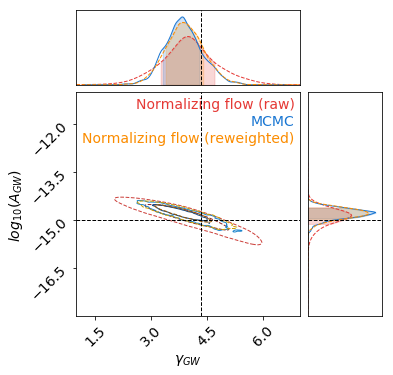

In [34]:

c = ChainConsumer()

c.add_chain(pars[:,[1,0]], parameters=["$\gamma_{GW}$", "$log_{10}(A_{GW})$"],\
            color='red',name='Normalizing flow (raw)',shade=False,linestyle='dashed')


c.add_chain(mcmcpoints[1],\
parameters=["$\gamma_{GW}$", "$log_{10}(A_{GW})$"],name='MCMC',color='blue',\
           shade=False)

c.add_chain(pars[:,[1,0]],weights=weights,\
parameters=["$\gamma_{GW}$", "$log_{10}(A_{GW})$"],name='Normalizing flow (reweighted)',color='orange',\
           shade=False,linestyle='dashed')

c.configure(label_font_size=14, tick_font_size=14)

fig = c.plotter.plot(display=True,figsize="column", truth=[13/3,-15],extents={"$log_{10}(A_{GW})$": (-18,-11),\
                                                                                "$\gamma_{GW}$": (1,7)})


In [21]:
fig.savefig('posterior_reweighted.pdf',bbox_inches='tight')